In [804]:
from data.load_idf_10_24 import load_base_model, get_df_i
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

In [805]:
data = load_base_model()

Data Frame idf_10_24MODEL récupéré depuis S3


In [806]:
dfs = get_df_i(data)

In [807]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from imblearn.over_sampling import SMOTE

In [808]:
test = dfs[1]
test["montantCapital"] = test["montantCapital"].apply(lambda x : 0 if x == "non-disp" else float(x))
test = test.drop_duplicates(subset=["siren"])


In [809]:
X1 = (test[["cp","taille_ville","mean_age","nb_associe","nb_local_concurrents",
"revCommune","sumxp","sumxp_rad","codeAPE","montantCapital","personneMorale","micro","revDep"]])
y1 = test["radié2"]

In [810]:
num_cols = ["nb_local_concurrents","revCommune","mean_age","montantCapital","revDep"]

X_trans = pd.get_dummies(X1)

X_trans[num_cols] = (X_trans[num_cols] - X_trans[num_cols].mean()) / X_trans[num_cols].std()

"""
train_obs = int(X_trans.shape[0]*0.8)
x_train = X_trans.iloc[0:train_obs,]
x_test = X_trans.iloc[train_obs:,]
y_train = y1[0:train_obs]
y_test = y1[train_obs:]
"""

x_train, x_test, y_train, y_test = train_test_split(X_trans, y1, test_size=0.2,shuffle=True,random_state=0)


In [811]:
sm = SMOTE()
x_res, y_res = sm.fit_resample(x_train, y_train)

In [812]:
model = LogisticRegression(random_state = 0, class_weight={0:1,1:10},solver = "liblinear", max_iter = 500)

In [813]:
model.fit(x_res,y_res)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*","{0: 1, 1: 10}"
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",0
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :t

In [814]:
y_prob = model.predict_proba(x_test)[:,1]

In [815]:
#Selection du seuil optimal selon  
th = np.linspace(0,1,1000)
f2 = []

for i in th:
    y_pred = [1 if p >= i else 0 for p in y_prob]
    f2_it = fbeta_score(y_test,y_pred,beta=2)
    f2.append(f2_it)

max_index = f2.index(np.max(f2))
best_th = th[max_index]

In [816]:
print(best_th)

0.8288288288288288


In [817]:
y_pred = [1 if p >= best_th else 0 for p in y_prob]

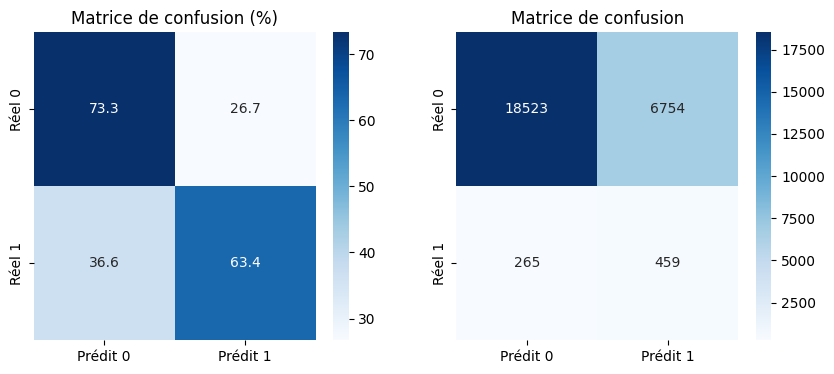

auc :  0.7321148798385709
f1 :  0.11566082902860023
f2 :  0.22702542289049363
accuracy :  0.7300488442752202
precision :  0.06363510328573409
recall :  0.6339779005524862


In [818]:

# Création de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# y_true = vraies classes
# y_pred = prédictions du modèle
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100 

fig, ax = plt.subplots(1,2,figsize=(10,4))

sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Prédit 0", "Prédit 1"],
            yticklabels=["Réel 0", "Réel 1"], ax = ax[0])
ax[0].set_title("Matrice de confusion (%)")

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Prédit 0", "Prédit 1"],
            yticklabels=["Réel 0", "Réel 1"], ax = ax[1])
ax[1].set_title("Matrice de confusion")

plt.show()

print("auc : ", roc_auc_score(y_test,y_prob))
print("f1 : ", f1_score(y_test,y_pred))
print("f2 : ", fbeta_score(y_test,y_pred,beta=2))
print("accuracy : ", accuracy_score(y_test,y_pred))
print("precision : ", precision_score(y_test,y_pred))
print("recall : ", recall_score(y_test,y_pred))